#### include library code

In [1]:
using Random
using Plots
using DataFrames
using CSV

#### define industries

In [2]:
mutable struct Industry
    # number of jobs available
    num_jobs :: Float64 #Int
    # job hire rate
    hirer :: Float64
    # rate of job loss
    firer :: Float64
end

# no jobs, no one is hired, no one loses their job
Industry() = Industry(0,0,0)

Industry

#### define countries

In [3]:
mutable struct Country
    migration_rate :: Float64
    industries :: Vector{Industry}
end

# no one migrates, no industries
Country() = Country(0,[])

Country

### define agents

In [4]:
mutable struct ComplexHuman
    migrant :: Bool
    employed :: Bool
    industry :: Int
    origin :: Country
    residence :: Country
    contacts :: Vector{ComplexHuman}
end

ComplexHuman() = ComplexHuman(false, true, 1, Country(), Country(), [])
ComplexHuman(country) = ComplexHuman(false, true, 1, country, country, [])

ComplexHuman

#### define simulation

In [5]:
mutable struct Simulation
    countries :: Vector{Country}
    # communication rate between agents
    commr :: Float64
    # and this is our population of agents
    pop :: Vector{ComplexHuman}
end

#### updating functions

In [6]:
function update_migrant_status!(person, sim)
    # for simplicity, we are not considering return migration
    # you can only go from non-migrant to migrant status
    if person.migrant == true
        return
    else
        # check all of the non-migrants contacts
        for contact in person.contacts
            # if the contact is a migrant & employed & they communicate more than random
            # then the person can become a migrant
            if contact.migrant == true && contact.employed == true && rand() < sim.commr
                person.migrant == true
                # in a more complex version, could do this:
                # person.residence == contact.residence
                # for now, settle for random
                person.residence == rand(person.contacts).residence
            end
        end
    end
end


function update_migrant_employment!(person, sim)
    # for simplicity, only change employment status of migrants
    if person.migrant == false
        return
    else
        if person.employed == true
            # random, for simplicity, but could be empirically determined
            if rand() < industry.firer
                person.employed == false
        else
            for contact in person.contacts
                if contact.migrant == true && contact.employed == true
                    if rand() < industry.hirer
                        person.employed == true
                        # a person would be in the same industry as their contact
                        # person.industry = contact.industry
                        # but for simplicity:
                        person.industry == rand(person.contacts).industry
                    end
                end
            end
        end
    end
end
end


function update!(agent, sim)
    update_migrant_status!(agent, sim)
    update_migrant_employment!(agent, sim)
end


function update_migrants!(sim)
    # we need to change the order, otherwise agents at the beginning of the 
    # pop array will behave differently from those further in the back
    order = shuffle(sim.pop)
    for p in order
        update!(p, sim)
    end
end

update_migrants! (generic function with 1 method)

#### setup functions

In [7]:
# job acquisition rate
const HIRER = 0.8
# job loss rate
const FIRER = 0.06
# ^^ should these sum to 1?
# migration rate
const MIGR = 0.035

0.035

In [8]:
# to scale the rate *slightly* to improve stability
scale_rate(rate, SCALAR::Float64 = 0.2) = rate + rand() * SCALAR - rand() * SCALAR

scale_rate (generic function with 2 methods)

In [9]:
function setup_industries!(n, num_jobs, country, HIRER, FIRER)
    country.industries = [ 
        Industry(rand() * num_jobs, scale_rate(HIRER), scale_rate(FIRER))
        for i=1:n ]
end

setup_industries! (generic function with 1 method)

In [11]:
function setup_countries(n, num_industries, num_jobs, MIGR, HIRER, FIRER)
    countries = [ Country(scale_rate(MIGR), []) for i=1:n ]
    for country in countries
        setup_industries!(num_industries, num_jobs, country, HIRER, FIRER)
    end
    countries
end

setup_countries (generic function with 1 method)

In [12]:
# trying to debug, there's something wront w/ setup_countries I think
setup_countries(5, 10, 50, MIGR, HIRER, FIRER)

5-element Array{Country,1}:
 Country(0.044032173484808756, Industry[Industry(35.95199176197909, 0.9775947102554274, 0.040046490328846523), Industry(42.52178868259268, 0.7665114648888847, -0.038383566431338445), Industry(10.118658886197462, 0.8779494868434073, -0.004071486005225972), Industry(28.214707556455686, 0.763826183550874, 0.033989490127055016), Industry(48.08402998963114, 0.8264013567276474, 0.024172793070373316), Industry(0.8047185398658341, 0.9402523539728297, 0.1659317880784546), Industry(33.03426253729167, 0.793624061142452, 0.17949369673431526), Industry(15.606564891369423, 0.8406331929514884, 0.035332670242705866), Industry(29.29246317465185, 0.6953411033365804, -0.0678279085230055), Industry(28.26388480293773, 0.8242364646358111, -0.010082242131824445)])
 Country(0.12083740447799847, Industry[Industry(28.002791610996546, 0.7559162632526523, -0.03980466773782246), Industry(31.8197653850929, 0.7937952515146791, -0.002796003121585927), Industry(18.63209113714259, 0.73313824

In [13]:
# if we skip the `if rand() < p_contact` line,
# all connections will be in eachother connections list 
# we could try to make a country-level probability contact
# but it should be placed into the country struct then in the setup_coutry f'n
# like `p_contact = rand()` and then loop somehow through it
# would loop through the people and see if they are connected
function setup_pop(n)
    pop = [ ComplexHuman() for i=1:n ]
    for i in eachindex(pop)
        for j in i+1:length(pop)
            if pop[i].origin == pop[j].origin
                push!(pop[i].contacts, pop[j])
                push!(pop[j].contacts, pop[i])
            end
        end
    end
    pop
end

setup_pop (generic function with 1 method)

In [ ]:
function pop_to_countries(pop, countries)
    for i in lenght(pop)
     pop[i].residence == rand(countries)
    end
end

In [14]:
function  setup_sim(;commr, N, num_jobs, num_industries, num_countries, seed)
    # for reproducibility
    Random.seed!(seed)

    # create a population of agents
    pop = setup_pop(N)
    
    # create our countries
    # within each country a number of industries are created
    countries = setup_countries(num_countries, num_industries, num_jobs, MIGR, HIRER, FIRER)
    @assert countries != nothing
    
    # create a population of agents
    pop = setup_pop(N) #should we change setup_pop coherently to work with countires..right?
    pop = pop_to_countries(pop, countries)

    # create a simulation object with parameter values
    sim = Simulation(countries, commr, pop)

end

setup_sim (generic function with 1 method)

testing DFs

In [ ]:
using DataFrames
df = DataFrame(A = 1:4, B = ["M", "F", "F", "M"])

push!(df, (5, "x"))

In [ ]:
randstring(['M'; 'F'], 1)

In [ ]:
rand(1:4)

In [ ]:
for i in 1:5
    push!(df,(rand(1:4), randstring(['M'; 'F'], 1)))
end
df

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1278


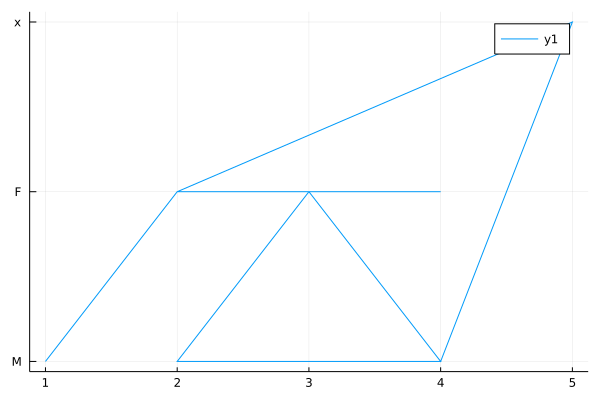

In [29]:
using StatsPlots
gr()
@df df plot(:A, :B)

In [15]:
output = DataFrame(status = [], country = [],employed = [], industry=[])

,status,country,employed,industry
,Any,Any,Any,Any


In [16]:
function run_sim(sim, n_steps, verbose = true)
    # we keep track of the numbers
#     n_non_migrants = Int[]
#     n_migrants = Int[]
    # add dataframe for unemployed, employed, industry, etc.
    # could use an array of arrays, depends on what we want to plot
    # for the google
    # could also produce data files as outputs
    # arg = open(file_name, 'w')
    # println(arg, stuff-to-write)
    # within notebook, open file.jl
    # use f'n include(), which reads julia code and executes
    # run f'n w/ a couple args, get the data
    # use notebook for displaying results

    # simulation steps
    for t in 1:n_steps
        update_migrants!(sim)
#         push!(n_migrants, count(p -> p.migrant == true, sim.pop))
#         push!(n_non_migrants, count(p -> p.migrant == false, sim.pop))
        for p in pop
            push!(output, (output.status, pop[p].migrant, pop[p].residence,pop[p].employed, pop[p].industry))
        # a bit of output
        if verbose
            println(t, ", ", n_migrants[end], ", ", n_non_migrants[end])
            end
        end
    end
       
    # return the results (normalized by pop size)
    n = length(sim.pop)
    n_migrants./n, n_non_migrants./n
end

run_sim (generic function with 2 methods)

In [17]:
sim = setup_sim(commr=0.2, N=1000, num_jobs=800, num_industries=10, num_countries=5, seed=42)
migrants, non_migrants = run_sim(sim, 500)
CSV.write("C:/Users/panze/Desktop/output.csv", output)
# Plots.plot([migrants, non_migrants], labels = ["Migrants" "Non-Migrants"])

LoadError: MethodError: no method matching setup_pop(::Int64, ::Array{Country,1})
Closest candidates are:
  setup_pop(::Any) at In[13]:7

#### run

FOR PLOT LOOK AT PLOT 0

IN RUN FUNCTION CALCULATE AN ARRAY OF NUMBER OF INTERESTS AN PLOT THAT ONE.